# 🤗 프로젝트 : 커스텀 프로젝트 직접 만들기

klue/bert-base 를 사용하여 NSMC task를 수행하라.
> - https://huggingface.co/klue/bert-base
> - https://github.com/e9t/nsmc

### 평가항목 1:

- sentence piece를 사용해 토크나이징 한 후
- klue/bert-base를 특성추출기로 사용해 base-line 성능을 기록했다.

### 평가항목 2: 

- 적절한 전처리와 fine-tuning을 통해 val_acc를 90% 이상 달성했다.

### 평가항목 3:

- 클래스 분포를 살펴보고 Bucketing을 수행하여 어떤 효과를 기대할 수 있는지 예상한 결과를 기록했다.

- Bucketing을 수행하여 finetuning 시 연산속도와 모델성능간의 trade-off관계가 발생하는지 여부를 확인하고 분석한 결과를 제시하였다.

## Step 1 : preprocessing

In [8]:
# excel 파일에 outline 같이 짜기
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2023-02-13 02:40:36--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.06s   

2023-02-13 02:40:36 (78.9 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]



In [1]:
# 데이터 다운로드 되었는지 확인
!ls rating*

ratings_test.txt  ratings_train.txt


In [2]:
# pandas library 확인
import pandas as pd
import numpy as np

In [3]:
# pandas 로 다운로드 파일 데이터프레임 생성
train = pd.read_table('./ratings_train.txt')
test = pd.read_table('./ratings_test.txt')

In [4]:
train_cp = train.copy()
test_cp = test.copy()

In [5]:
idx = train_cp['document'].duplicated()

In [6]:
# 데이터 확인
train.info() # null-value 확인 5개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [7]:
# 데이터 확인
test.info() # null-value 확인 3개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [8]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
# document length
train['doc_len'] = train['document'].apply(lambda x: len(str(x)))
test['doc_len'] = test['document'].apply(lambda x: len(str(x)))

<AxesSubplot:>

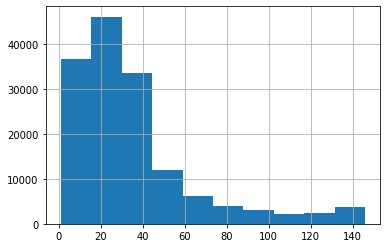

In [11]:
train.doc_len.hist()

<AxesSubplot:>

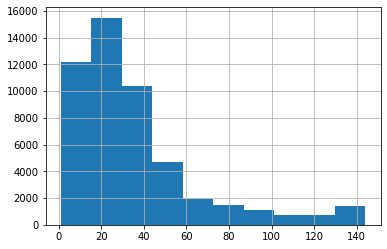

In [12]:
test.doc_len.hist()

In [13]:
# null 값 있는 자료 삭제
n_idx_tr = train.loc[train['document'].isnull()].index
train.drop(index=n_idx_tr, inplace=True)
train.loc[train['document'].isnull()]

,id,document,label,doc_len


In [14]:
print(train['doc_len'].max())

146


In [15]:
# null 값 있는 자료 삭제
n_idx_ts = test.loc[test['document'].isnull()].index
test.drop(index=n_idx_ts, inplace=True)
test.loc[test['document'].isnull()]

,id,document,label,doc_len


In [16]:
print(test['doc_len'].max())

144


In [17]:
# 중복 확인
print(len(train.loc[train['document'].duplicated()]))
print(train['document'].duplicated().sum())

3813
3813


In [18]:
# 중복 확인
print(len(test.loc[test['document'].duplicated()]))
print(test['document'].duplicated().sum())

840
840


In [19]:
#중복 삭제
train = train.drop_duplicates(subset='document')
test = test.drop_duplicates(subset='document')

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
 3   doc_len   146182 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
 3   doc_len   49157 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.9+ MB


In [45]:
all_doc = np.concatenate((train['document'].values,test['document'].values)) 

In [46]:
import re

In [47]:
def clean_sentence(sentence):
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z!.,?]+", " ", sentence)
        return sentence

In [48]:
filtered_corpus = []
for i in all_doc :
    sentence = clean_sentence(i)
    filtered_corpus.append(sentence)
train_f = filtered_corpus[:146182]
test_f = filtered_corpus[146182:]
all_doc_f = np.concatenate((train_f,test_f))

In [51]:
test['document'].head()

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
Name: document, dtype: object

In [50]:
train_f = filtered_corpus[:146182]
test_f = filtered_corpus[146182:]

In [53]:
all_doc_f = np.concatenate((train_f,test_f))

## Step 2 : tokenizing

In [54]:
#unique한 단어 확인

temp_doc= set()
for i in all_doc_f :
    temp_doc |= set(i.split())
    
len(temp_doc)

356896

In [56]:
#sentence piece model training

import sentencepiece as spm
temp_file = 'nlp16.train.ko.temp'
vocab_size = 35000

with open(temp_file, 'w') as f:
    for row in all_doc:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train( 
    '--input={} --model_prefix=nlp16 --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=nlp16.train.ko.temp --model_prefix=nlp16 --vocab_size=35000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: nlp16.train.ko.temp
  input_format: 
  model_prefix: nlp16
  model_type: UNIGRAM
  vocab_size: 35000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_p

In [57]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load(f'nlp16.model')

True

In [62]:
test_txt = '아빠가 가방을 들고 있어요'

In [63]:
tokenizer.EncodeAsPieces(test_txt)

['▁아빠가', '▁가방', '을', '▁들고', '▁있어요']

In [64]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("klue/bert-base")
tokenizer_k = AutoTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [76]:
# sentence piece 와 bert 모델 토크나이져와 사용 불가
tokenizer.EncodeAsPieces(test_txt)

['▁아빠가', '▁가방', '을', '▁들고', '▁있어요']

In [75]:
tokenizer_k.tokenize(test_txt)

['아빠', '##가', '가방', '##을', '들', '##고', '있', '##어요']

## Step 3 : modeling

## Step 4 : evaluation